# Hyperview

## Updates:
### 27.05.2024
* tested channelwise normalization $(x-mu)/std$. It gave worse results then $x/max$ (negative values seemed to cause the problem)
* changed final activation for shift to tanh. This allowed to reduce the effect of accumulation of hats, what seemed to be an issue before.
* changed img size to 10x10 to avoid padding (for now, to make sure it doesn't influence the model)

Result: much better predictions, finally not only averaging


### 09.05.2024
* dividing by max value, so all values are (0, 1)
* sigmoid as final activation in modeller, then mu and sigma are multiplied by 150 in renderer
* shift instead of intensity (adding constant instead of multiplying)
* verification of spectral curves for each pixel

Result: the predicted spectral curve seems to be averaged target curve

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.stats import norm
from torch import Tensor
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.data.dataset import HyperviewDataset

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

## Dataset
Ignoring image masks for now, using regular images and cropping them.

In [4]:
SIZE = 10
max_val = 5500

In [5]:
# channelwise statistics calculated beforhand

with open("data/hyperview/stats/std_c.npy", "rb") as f:
    sigma = np.load(f)

with open("data/hyperview/stats/mean_c.npy", "rb") as f:
    mu = np.load(f)

with open("data/hyperview/stats/max_c.npy", "rb") as f:
    maxx = np.load(f)

In [6]:
maxx[maxx > max_val] = max_val

In [7]:
dataset = HyperviewDataset("data/hyperview/train_data/train_data", SIZE, max_val, 0, maxx)

In [8]:
len(dataset)

1732

In [9]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [1400, 200, 132])

In [10]:
train_set[0].shape

torch.Size([150, 10, 10])

In [11]:
trainloader = DataLoader(train_set, batch_size=8, shuffle=True)
valloader = DataLoader(val_set, batch_size=8)
testloader = DataLoader(test_set, batch_size=8)

## Architectures

### Modeller
Output shaped N x K x 3 x H x W, K-number of triples (mu, sigma, shift) describing distributions.

In [12]:
class Modeller(nn.Module):
    def __init__(self, channels: int = 150, k: int = 2, size: int = 10):
        super(Modeller, self).__init__()
        self.k = k
        self.size = size
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=1)
        nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain("relu"))
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain("relu"))
        self.conv4 = nn.Conv2d(64, 3 * self.k, kernel_size=1)
        nn.init.xavier_uniform_(self.conv4.weight, gain=nn.init.calculate_gain("sigmoid"))

    def forward(self, x: Tensor) -> Tensor:
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv4(x)
        x = x.view(x.shape[0], self.k, 3, self.size, self.size)
        x[:, :, :2] = self.sigmoid(x[:, :, :2])
        x[:, :, 2] = self.tanh(x[:, :, 2]) # allow shift to be negative
        return x

### Renderer

In [13]:
class Renderer:
    def __init__(self) -> None:
        pass

    def __call__(self, batch: Tensor) -> Tensor:
        batch_size, k, params, h, w = batch.shape
        self.bands = torch.arange(150).float().repeat(k, h, w, 1).to(DEVICE)
        rendered = torch.zeros((batch_size, 150, h, w))

        for idx in range(batch_size):
            dists = self.generate_distribution(
                batch[idx, :, 0, ...], batch[idx, :, 1, ...], batch[idx, :, 2, ...]
            )
            pixel_dist = torch.sum(dists, dim=0)
            rendered[idx] = pixel_dist.permute(2, 0, 1)

        return rendered.to(DEVICE)

    def generate_distribution(self, mu: Tensor, sigma: Tensor, shift_pos: Tensor):
        eps = 1e-4
        sigma = torch.add(sigma, eps)
        normal_dist = Normal(150 * mu.unsqueeze(-1), 150 * sigma.unsqueeze(-1))
        return torch.exp(normal_dist.log_prob(self.bands)) + shift_pos.unsqueeze(-1)

#### Example of rendering

In [14]:
# two example hats
hat1 = [0.5, 1, 0]
hat2 = [1, 1, 1]

In [15]:
# reshaping to input compatible with renderer
t = Tensor([[hat1, hat2]]).unsqueeze(-1).unsqueeze(-1).to(DEVICE)
renderer = Renderer()
rendered = renderer(t)

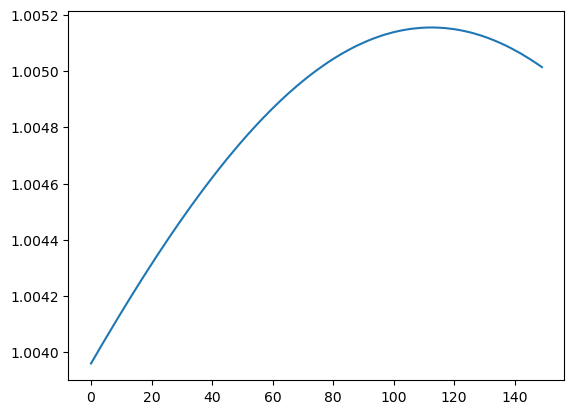

In [16]:
# two hats combined
plt.plot(1*rendered[0][:,0,0].cpu())

## Training

In [17]:
def train(
    model: nn.Module,
    trainloader: DataLoader,
    valloader: DataLoader,
    num_epochs: int,
    device: str,
    lr: float,
) -> tuple[nn.Module, list[float], list[float]]:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    renderer = Renderer()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        step_losses = []
        with tqdm(trainloader, unit="batch") as tepoch:
            for input in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                optimizer.zero_grad()
                input = input.to(device)
                y_pred = model(input)
                y_pred_r = renderer(y_pred)
                loss = criterion(y_pred_r, input)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                step_losses.append(loss.cpu().detach().numpy())
        train_losses.append(np.mean(step_losses))
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for i, vdata in enumerate(valloader):
                vinputs= vdata.to(device)
                voutputs = model(vinputs)
                voutputs_r = renderer(voutputs)
                vloss = torch.sqrt(criterion(voutputs_r, vinputs))
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        val_losses.append(avg_vloss.cpu())
        scheduler.step()
    return model, train_losses, val_losses

In [18]:
model = Modeller(k=5, size=SIZE).to(DEVICE)
model, tloss, vloss = train(model, trainloader, valloader, 20, DEVICE, 1e-4)

Epoch 0:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 19: 100%|██████████| 175/175 [00:01<00:00, 116.47batch/s, loss=0.00805]


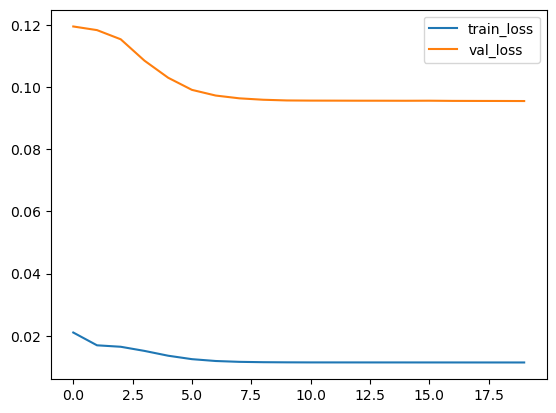

In [19]:
plt.plot(tloss, label="train_loss")
plt.plot(vloss, label="val_loss")
plt.legend()
plt.show()

## Results

In [20]:
renderer = Renderer()
imgs = []
outputs = []
for img in testloader:
    out = model(img.to(DEVICE))
    rendered = renderer(out)
    imgs.append(img)
    outputs.append(rendered)

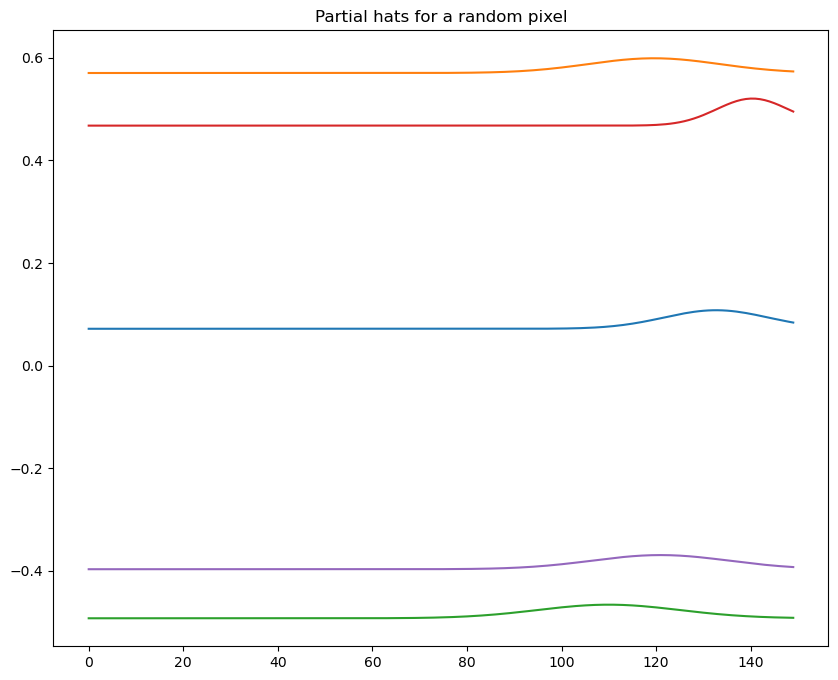

In [21]:
idx = 0
fig, ax = plt.subplots(figsize=(10, 8))
pixel1_hats = out[idx, ..., 9, 9]

for stats in pixel1_hats:
    stats = stats.cpu().detach().numpy()
    # print(stats)
    dist = norm.pdf(range(0, 150), 150*stats[0], 150*stats[1]) + stats[2]
    ax.plot(dist)
plt.title("Partial hats for a random pixel")
plt.show()

In [22]:
out.shape

torch.Size([4, 5, 3, 10, 10])

In [23]:
rendered.shape

torch.Size([4, 150, 10, 10])

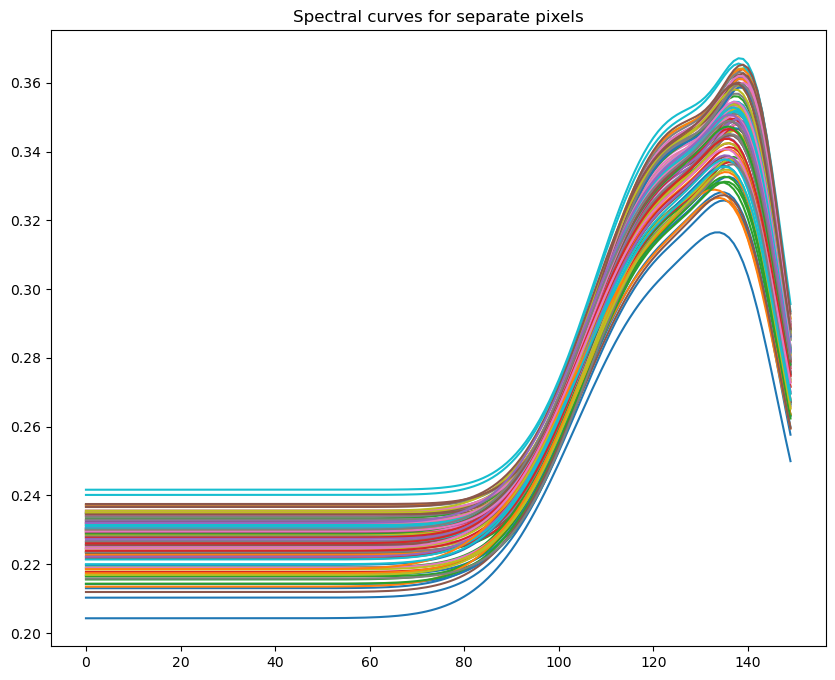

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(10):
    for j in range(10):
        pixel1_hats = rendered[idx, ..., i, j]
        ax.plot(pixel1_hats.cpu().detach().numpy())
plt.title("Spectral curves for separate pixels")
plt.show()

In [25]:
i = 1
gt_img = imgs[0][i]
pred_img = outputs[0][i].cpu().detach().numpy()

Text(0.5, 1.0, 'PRED')

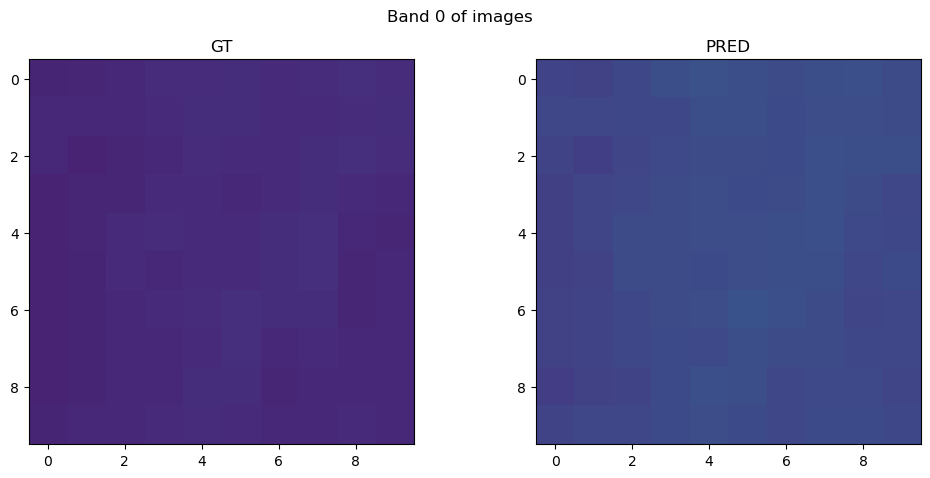

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Band 0 of images")
axs[0].imshow(gt_img[0], vmin=0, vmax=1)
axs[0].set_title("GT")
axs[1].imshow(pred_img[0], vmin=0, vmax=1)
axs[1].set_title("PRED")

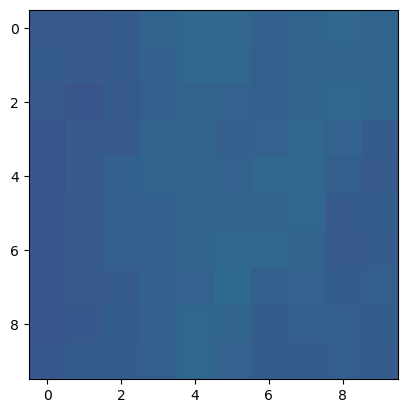

In [26]:
# original image - band0
plt.imshow(gt_img[100], vmin=0, vmax=1)

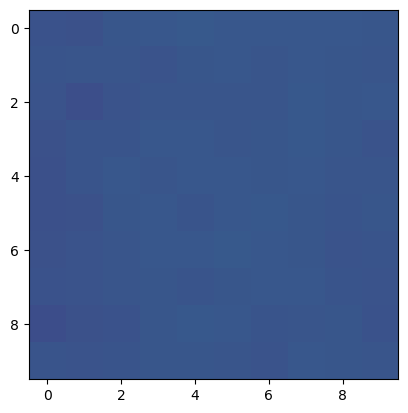

In [27]:
# reconstructed image - band0
plt.imshow(pred_img[100], vmin=0, vmax=1)

In [36]:
fig = plt.figure(figsize=(10, 5))

gt_mean_spectral_reflectance = [gt_img[i].mean() for i in range(gt_img.shape[0])]
pred_mean_spectral_reflectance = [pred_img[i].mean() for i in range(pred_img.shape[0])]

plt.plot(pred_mean_spectral_reflectance, label="PRED")
plt.plot(gt_mean_spectral_reflectance, label="GT")

plt.xlabel("band")
plt.legend()
plt.title("Average reflectance")
plt.show()

AttributeError: 'Figure' object has no attribute 'plot'

<Figure size 1000x500 with 0 Axes>

Seems like predictions are averaging GT.

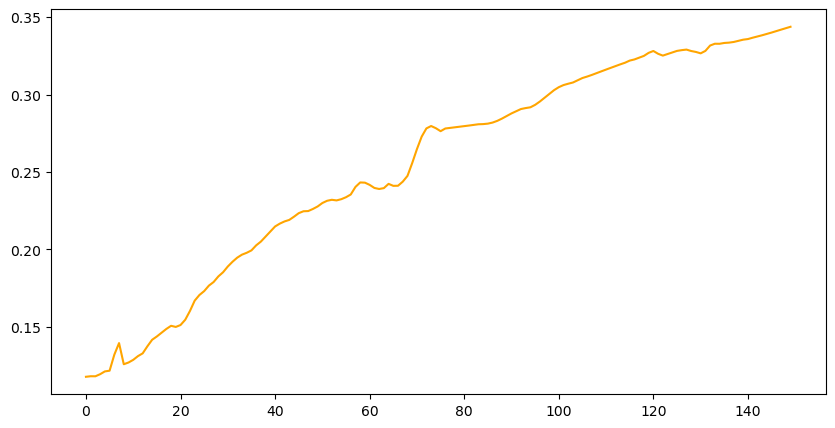

In [29]:
fig = plt.figure(figsize=(10, 5))
plt.plot(gt_mean_spectral_reflectance, label="GT", color="orange")
plt.show()

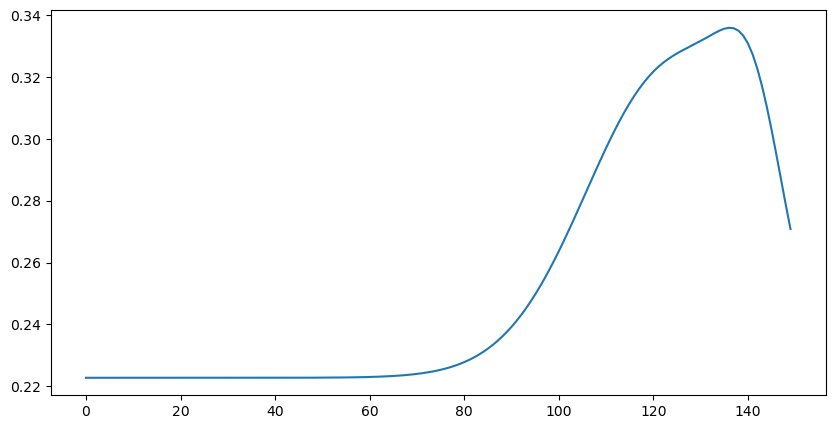

In [30]:
fig = plt.figure(figsize=(10, 5))
plt.plot(pred_mean_spectral_reflectance, label="PRED")
plt.show()

### Spectral curves for every pixel

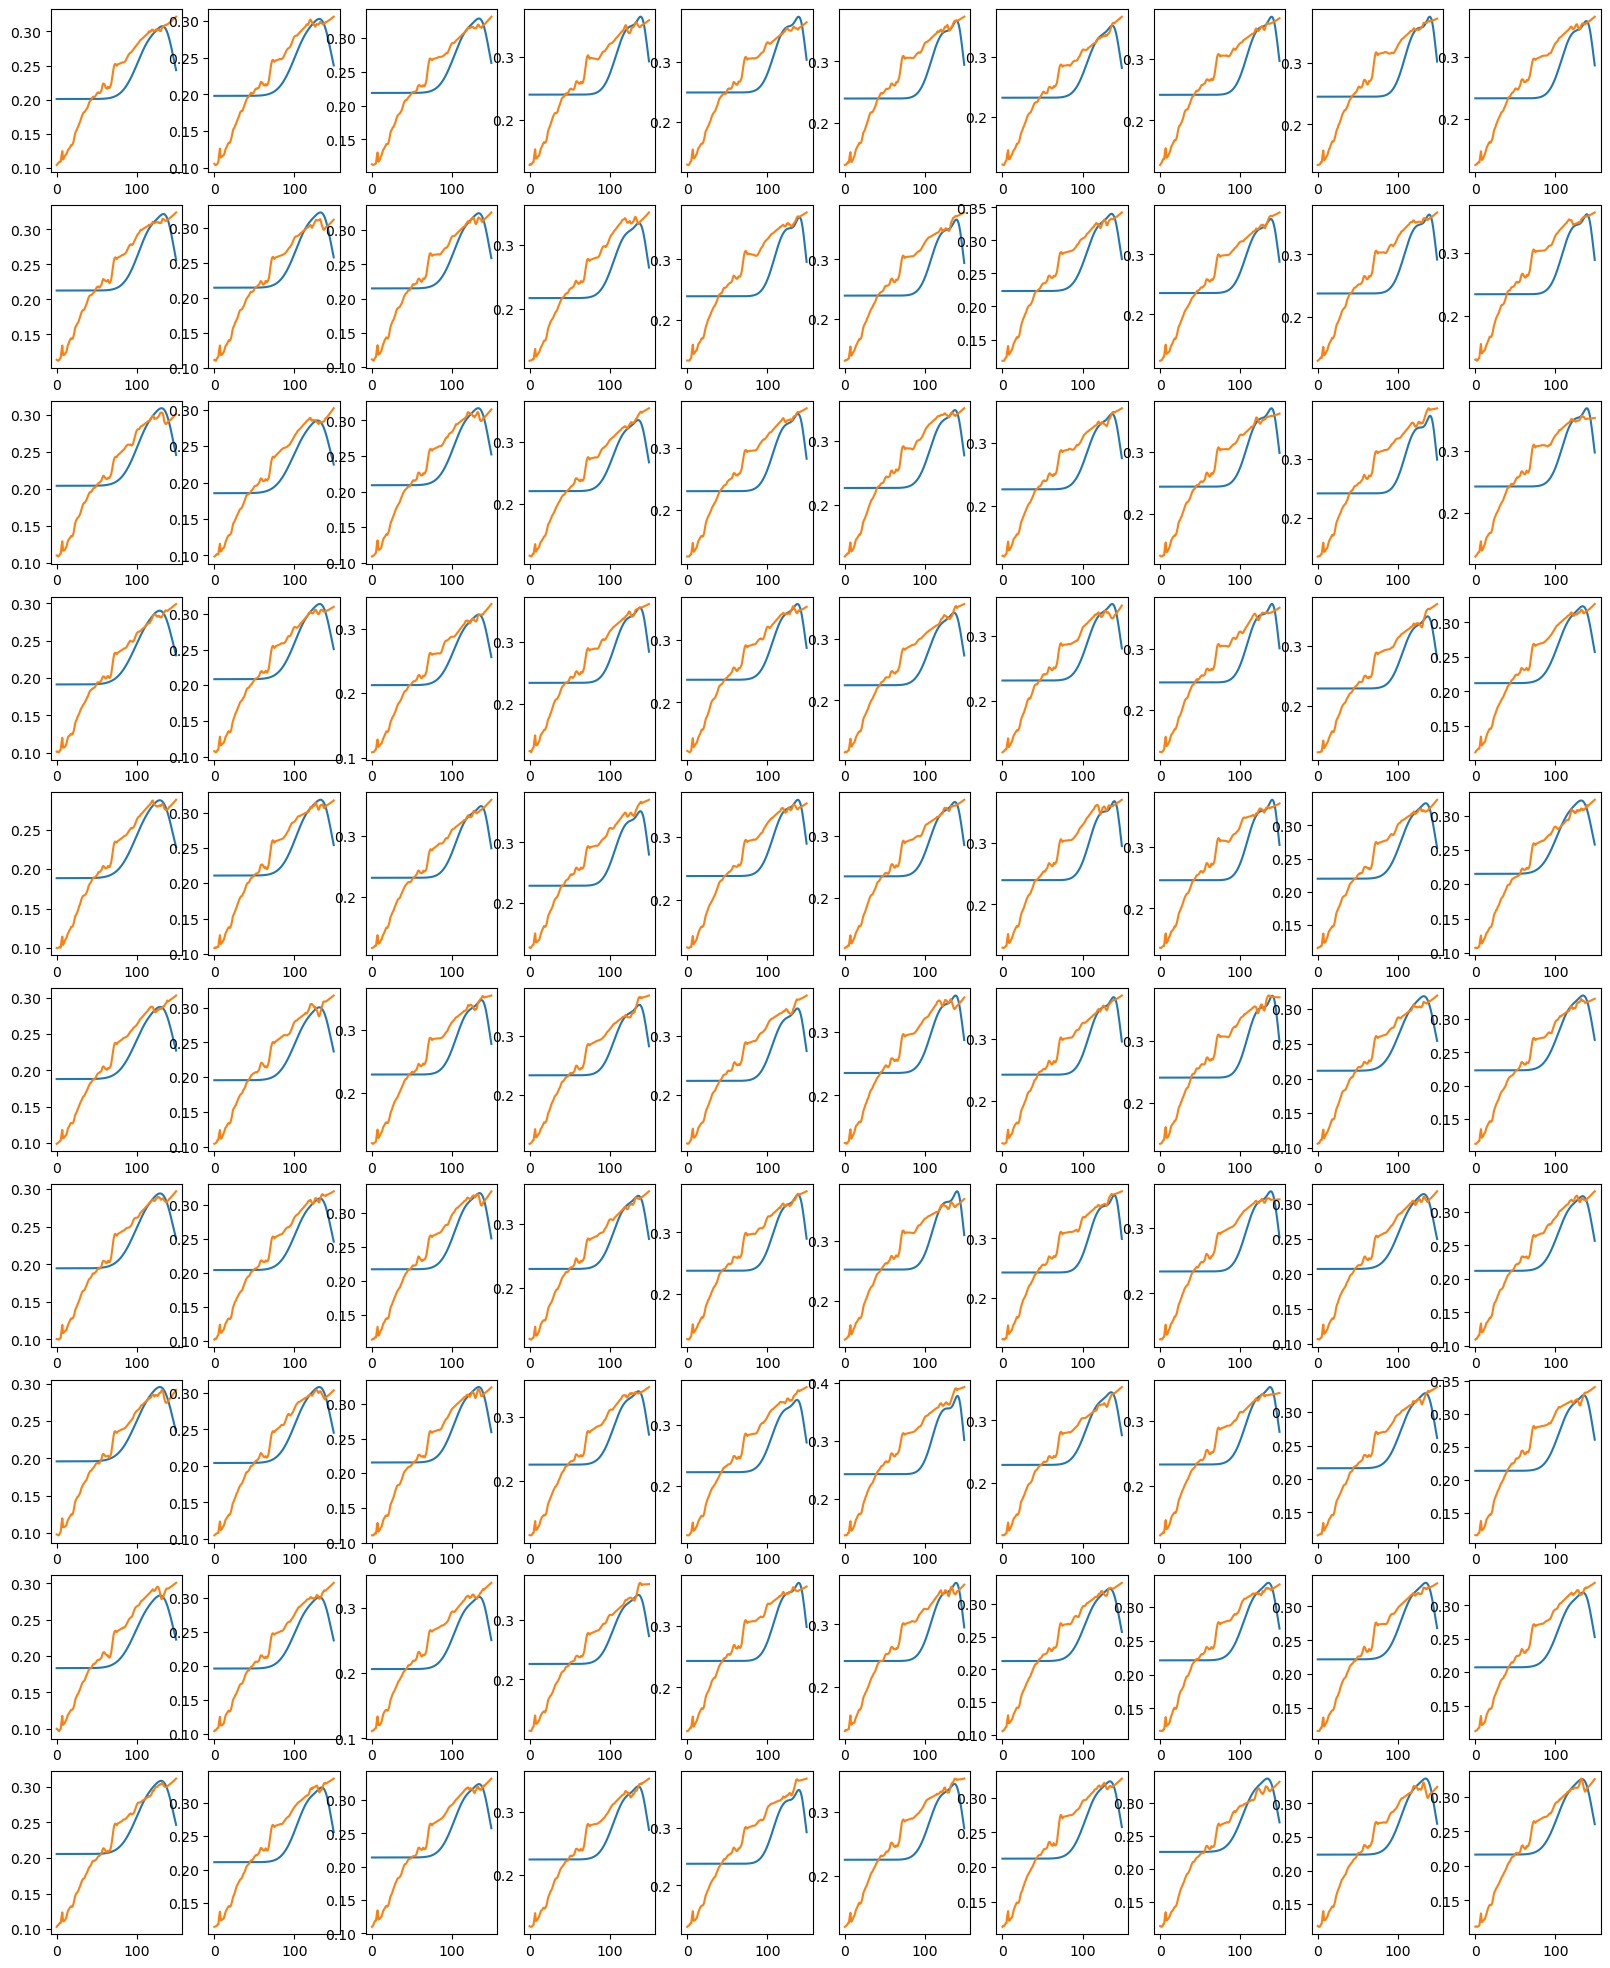

In [31]:
fig, axs = plt.subplots(SIZE, SIZE, figsize=(20, 25))

for i in range(SIZE):
    for j in range(SIZE):
        axs[i,j].plot(pred_img[:,i,j])
        axs[i,j].plot(gt_img[:,i,j])
plt.savefig("spectral_curves.png")